In [63]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, LSTM, Bidirectional, TimeDistributed, Concatenate, Flatten, Attention
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import tensorflow as tf

In [79]:
# Load and preprocess the data
all_news = "D:/Dataset/Fake_News_Dataset_Malayalam/mal_fake_train.csv"
all_df = pd.read_csv(all_news)

true_df = all_df[all_df["label"] == "original"]
fake_df = all_df[all_df["label"] == "Fake"]
true_df.loc[:, "label"] = 1  # 1 for true news
fake_df.loc[:, "label"] = 0  # 0 for fake news

# Combine the datasets
df = pd.concat([true_df, fake_df], ignore_index=True)

all_news_1 = "D:/Dataset/Fake_News_Dataset_Malayalam/mal_fake_test_with_labels.csv"
all_df_1 = pd.read_csv(all_news_1)


true_df_1 = all_df_1[all_df_1["label"] == "original"]
fake_df_1 = all_df_1[all_df_1["label"] == "Fake"]
true_df_1.loc[:, "label"] = 1  # 1 for true news
fake_df_1.loc[:, "label"] = 0  # 0 for fake news


df1 = pd.concat([true_df_1, fake_df_1], ignore_index=True)

X_train = df['text']
y_train = df['label']

X_test = df1['text']
y_test = df1['label']

# Split the data
# X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)

# Tokenize the text
max_words = 10000
max_len = 200

tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')
# Convert to float32
X_train_pad = X_train_pad.astype('float32')
X_test_pad = X_test_pad.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')


In [80]:
def create_textcnn_model():
    inputs = Input(shape=(max_len,))
    embedding = Embedding(max_words, 100, input_length=max_len)(inputs)
    
    conv_layers = []
    for filter_size in [3, 4, 5]:
        conv = Conv1D(128, filter_size, activation='relu')(embedding)
        pool = GlobalMaxPooling1D()(conv)
        conv_layers.append(pool)
    
    concat = Concatenate()(conv_layers)
    dropout = Dropout(0.5)(concat)
    outputs = Dense(1, activation='sigmoid')(dropout)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model


In [81]:
def create_rcnn_model():
    inputs = Input(shape=(max_len,))
    embedding = Embedding(max_words, 100, input_length=max_len)(inputs)
    
    lstm = Bidirectional(LSTM(64, return_sequences=True))(embedding)
    conv = Conv1D(128, 3, activation='relu')(lstm)
    pool = GlobalMaxPooling1D()(conv)
    
    dropout = Dropout(0.5)(pool)
    outputs = Dense(1, activation='sigmoid')(dropout)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [82]:
def create_han_model():
    inputs = Input(shape=(max_len,))
    embedding = Embedding(max_words, 100, input_length=max_len)(inputs)
    
    lstm = Bidirectional(LSTM(64, return_sequences=True))(embedding)
    attention_layer = Attention()([lstm, lstm])
    
    flatten = Flatten()(attention_layer)
    dropout = Dropout(0.5)(flatten)
    outputs = Dense(1, activation='sigmoid')(dropout)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [83]:
def create_ensemble_model(models):
    inputs = Input(shape=(max_len,))
    outputs = [model(inputs) for model in models]
    ensemble_output = Concatenate()(outputs)
    ensemble_output = Dense(1, activation='sigmoid')(ensemble_output)
    ensemble_model = Model(inputs=inputs, outputs=ensemble_output)
    return ensemble_model

In [84]:
textcnn_model = create_textcnn_model()
rcnn_model = create_rcnn_model()
han_model = create_han_model()

In [85]:
ensemble_model = create_ensemble_model([textcnn_model, rcnn_model, han_model])


In [86]:
ensemble_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


In [87]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [88]:
X_train_tensor = tf.convert_to_tensor(X_train_pad, dtype=tf.float32)
y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.float32)


In [89]:
history = ensemble_model.fit(
    X_train_tensor, y_train_tensor,
    epochs=20,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping]
)


Epoch 1/20
41/41 [==============================] - 42s 766ms/step - loss: 0.6358 - accuracy: 0.6372 - val_loss: 0.8332 - val_accuracy: 0.0475
Epoch 2/20
41/41 [==============================] - 30s 732ms/step - loss: 0.5852 - accuracy: 0.8583 - val_loss: 0.5428 - val_accuracy: 0.9279
Epoch 3/20
41/41 [==============================] - 29s 697ms/step - loss: 0.5578 - accuracy: 0.9620 - val_loss: 0.5378 - val_accuracy: 0.9433
Epoch 4/20
41/41 [==============================] - 29s 704ms/step - loss: 0.5229 - accuracy: 0.9839 - val_loss: 0.5306 - val_accuracy: 0.9632
Epoch 5/20
41/41 [==============================] - 29s 714ms/step - loss: 0.4972 - accuracy: 0.9889 - val_loss: 0.5268 - val_accuracy: 0.9647
Epoch 6/20
41/41 [==============================] - 31s 752ms/step - loss: 0.4763 - accuracy: 0.9896 - val_loss: 0.5234 - val_accuracy: 0.9647
Epoch 7/20
41/41 [==============================] - 29s 698ms/step - loss: 0.4578 - accuracy: 0.9931 - val_loss: 0.5203 - val_accuracy: 0.9632

In [90]:
# Evaluate the model
X_test_tensor = tf.convert_to_tensor(X_test_pad, dtype=tf.float32)
y_test_tensor = tf.convert_to_tensor(y_test, dtype=tf.float32)
loss, accuracy = ensemble_model.evaluate(X_test_tensor, y_test_tensor)
print(f"Test accuracy: {accuracy:.4f}")


32/32 [==============================] - 2s 67ms/step - loss: 0.6673 - accuracy: 0.6075
Test accuracy: 0.6075


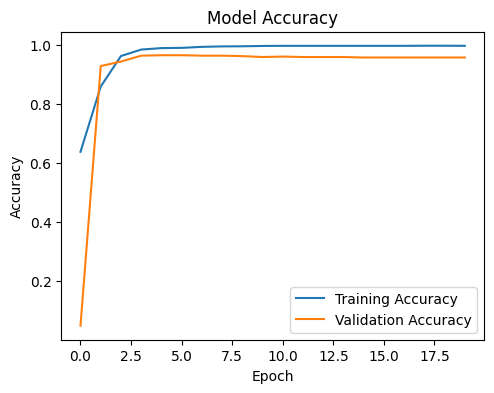

In [91]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

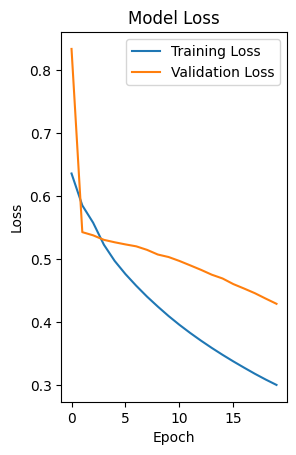

In [92]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


In [94]:
def predict_fake_news(text):
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=max_len, padding='post', truncating='post')
    padded = tf.convert_to_tensor(padded, dtype=tf.float32)
    prediction = ensemble_model.predict(padded)[0][0]
    return "Fake" if prediction < 0.5 else "Original", prediction

# Example usage
sample_text = "malayalam is a good alnfgg"
result, confidence = predict_fake_news(sample_text)
print(f"Prediction: {result}")
print(f"Confidence: {confidence:.4f}")

1/1 [==============================] - 0s 49ms/step
Prediction: Fake
Confidence: 0.3258
